In [1]:
import os
os.chdir('../../') # we run our script from two levels above (where main.py is)

import torch
import numpy as np
import matplotlib.pyplot as plt

TUTORIAL_DIR = 'src/_tutorials/example'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from src.utils import to_batch_one_tensor
from src.xai import compute_single_data_attribution,compute_attribution_score

In [3]:
from src.model import mabSPA
net = mabSPA().to(device=device)
checkpoint = torch.load(f"{TUTORIAL_DIR}/mabmodel_10_1.pt")
net.load_state_dict(checkpoint['model_state_dict'])
net.eval()
print('model loaded!')

model loaded!


In [4]:
from src.data import load_dataset_from_a_shard, save_one_chunk

SHARD_DIR = f"{TUTORIAL_DIR}/data.shard"
dargs = {'n_classes':3, 'n_per_shard':4,}
save_one_chunk(SHARD_DIR, dargs['n_classes'], dargs['n_per_shard'], realtime_update=False)
samples = load_dataset_from_a_shard(SHARD_DIR, reshape_size=None)

  data prepared.                                                



 ============ sample 0 ============
metrics_collection:
 thresholds                       pixel_acc  recall     precision  FPR        
[-0.7 -0.3  0.3  0.7]            0.972      0.987      0.911      0.033     
x.shape:(3, 256, 256)   label/pred:1/1    h0.shape:(256, 256) 
attr.shape:(1, 256, 256), max:0.9, min:0.0

 ============ sample 1 ============
metrics_collection:
 thresholds                       pixel_acc  recall     precision  FPR        
[-0.7 -0.3  0.3  0.7]            0.911      0.983      0.835      0.14      
x.shape:(3, 256, 256)   label/pred:0/0    h0.shape:(256, 256) 
attr.shape:(1, 256, 256), max:0.9, min:0.0

 ============ sample 2 ============
metrics_collection:
 thresholds                       pixel_acc  recall     precision  FPR        
[-0.7 -0.3  0.3  0.7]            0.973      0.966      0.947      0.024     
x.shape:(3, 256, 256)   label/pred:2/2    h0.shape:(256, 256) 
attr.shape:(1, 256, 256), max:0.9, min:0.0

 ============ sample 3 ============
metric

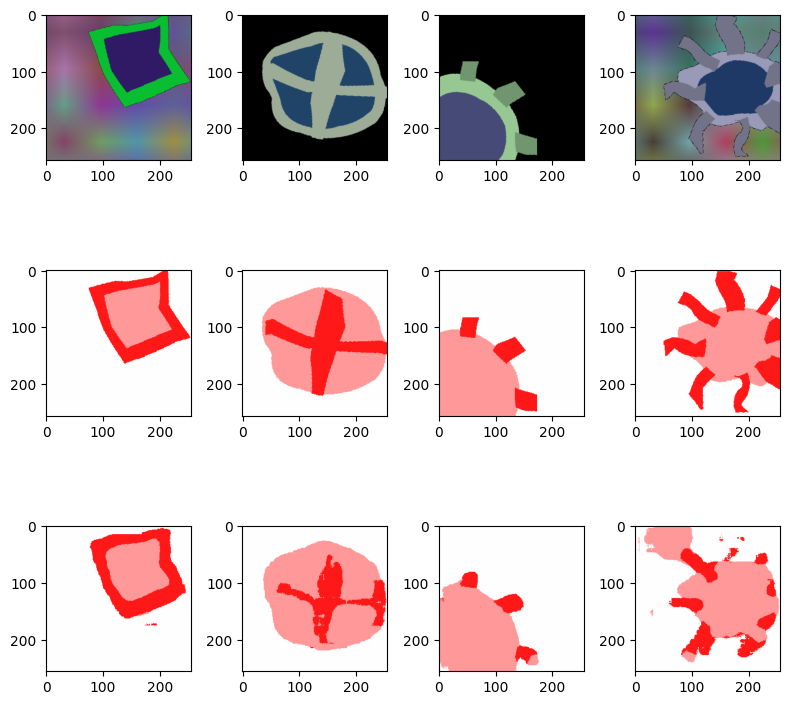

In [5]:
%matplotlib inline
plt.figure(figsize=(8,8))

with torch.no_grad():
    for i in range(dargs['n_per_shard']):
        print(f'\n ============ sample {i} ============')
        x,y0 = samples.__getitem__(i) # in numpy like (C,H,W) and int respectively
        h0 = samples.h[i] # in numpy, like (H,W), the groundtruth heatmap
        c,h_,w_ = x.shape
    
        net.forward_mode = 'label+heatmap'
        y,h = net(to_batch_one_tensor(x, device=device))
        y_pred = torch.argmax(y,dim=1)[0].detach().cpu().numpy()

        ########## XAI part here ############
        h1 = torch.argmax(h[:,:,:h_,:w_], dim=1)
        h1 = h1.clone().detach().cpu().numpy()
        attr = (h1==1)*0.4 + (h1==2)*0.9

        _ = compute_attribution_score(int(y_pred), int(y0), attr, h0,five_band_setting='mab', display_only=True)
        
        ########## let's plot ###############
        print(f'x.shape:{x.shape}   label/pred:{y0}/{y_pred}    h0.shape:{h0.shape} ') 
        print(f'attr.shape:{attr.shape}, max:{np.max(attr)}, min:{np.min(attr)}')
        plt.gcf().add_subplot(3,dargs['n_per_shard'],i+1)
        plt.gca().imshow(x.transpose(1,2,0))
        plt.gcf().add_subplot(3,dargs['n_per_shard'],i+1 + dargs['n_per_shard'])
        plt.gca().imshow(h0, vmin=-1,vmax=1.,cmap='bwr')
        plt.gcf().add_subplot(3,dargs['n_per_shard'],i+1 + 2*dargs['n_per_shard'])
        plt.gca().imshow(attr[0], vmin=-1,vmax=1.,cmap='bwr')
        
    plt.tight_layout()
    plt.show()